In [2]:
import numpy as np
import pandas as pd
import subprocess
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, KFold
import cv2
from sklearn.preprocessing import LabelEncoder
from color_recognition import color_histogram_feature_extraction
from color_recognition import knn_classifier
import os
import os.path
import sys
import matplotlib.pyplot as plt
from utils import *
from imutils.object_detection import non_max_suppression
from PIL import Image
from PIL import Image, ImageFilter
from PIL import ImageEnhance
import keras_ocr
from tqdm import tqdm
from difflib import SequenceMatcher
from sklearn.cluster import KMeans
from tensorflow.keras import backend as K


## Contents

### 1. Download Images
### 2. Bike color determination
### 3. Brand prediction
### 4. Classifier to check if the bike has a lamp.

## 1. Download Images from CSV

Reading the CSV, 'Case_BI_Data.csv', that was provided. Additional columns, Light(if the bike has a lamp or not), Gender(type of bike:male, female, hybrid) and Color(describing color of the bike) have been added manually.

In [5]:
file_path = 'Case_BI_Data.csv'
df = pd.read_csv(file_path)
df.head()

,model_name,brand_name,image_url,bike_category,Light,Gender,Color
0,Pasero SUV I-10,Hercules,https://rebike-photo-nas.s3.eu-central-1.amazo...,Trekking E-Bikes,Yes,Female,Grey
1,E-Power C29 SE 3.0 CX7 Belt Sport,Corratec,https://rebike-photo-nas.s3.eu-central-1.amazo...,City E-Bikes,Yes,Female,White
2,Acid,Cube,https://rebike-photo-nas.s3.eu-central-1.amazo...,Fahrrad Mountainbike,No,Male,White
3,Attention,Cube,https://rebike-photo-nas.s3.eu-central-1.amazo...,Fahrrad Mountainbike,No,Male,Black
4,Mavaro Neo 1,Cannondale,https://rebike-photo-nas.s3.eu-central-1.amazo...,City E-Bikes,Yes,Male,Black


In [ ]:
#Download images from the url

urls = df['image_url'].tolist()
for i,url in enumerate(urls):

    curl_command = ['curl', '-o', 'dataset/img_000'+str(i+1)+'.jpg', url]

    try:
        subprocess.run(curl_command, check=True)
    except subprocess.CalledProcessError as e:
        print("Failed to download image:", e)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1222k  100 1222k    0     0  4092k      0 --:--:-- --:--:-- --:--:-- 4103k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  415k  100  415k    0     0  1872k      0 --:--:-- --:--:-- --:--:-- 1878k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  1142k      0 --:--:-- --:--:-- --:--:-- 1141k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1093k  100 1093k    0     0  4049k      0 --:--:-- --:--:-- --:--:-- 4064k
  % Total    % Received % Xferd  Average Speed   Tim

100  402k  100  402k    0     0  1633k      0 --:--:-- --:--:-- --:--:-- 1637k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1005k  100 1005k    0     0  3123k      0 --:--:-- --:--:-- --:--:-- 3122k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1225k  100 1225k    0     0  3631k      0 --:--:-- --:--:-- --:--:-- 3636k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1143k  100 1143k    0     0  3569k      0 --:--:-- --:--:-- --:--:-- 3574k


## 2. Color Detetction by Clustering

1. Training images of different colors are stored in 'training_dataset_color/' folder. Histogram of each colour is calculated across the three channels(b,g,r) and the palette is stored in training.data with corresponding labels.


2. For a new image, the histogram is calculated across the three channels and the dominant color in the image is chosen to be the query colour. i.e, the bin with maximum value in each of the channel histograms is considered to be the query color which has to be assigned a label. Since the dominant color in the query color, cropping and masking operations are performed on the images to highlight the chassis.



<div style="display: flex;">
  <div style="flex: 50%; padding: 5px;">
    <img src="dataset/img_0001_cropped.jpg" alt="Image 1" width="400">
    <p style="text-align: center;">Cropped Image</p>
  </div>
  <div style="flex: 50%; padding: 5px;">
    <img src="pictures/segmented_image.jpg" alt="Image 2" width="210">
    <p style="text-align: center;">Corresponding mask for calculating histogram. Only the cells in white are considered. </p>
  </div>
</div>



3. Once the query colour is obtained from the image, the label is assigned using a k-means classifier with k=3

In [ ]:
#Crop images of bike chassis for colour detection. Check the dataset folder for the cropped images.
for i in list(range(len(urls))):
    crop_image('img_000'+str(i+1))

In [ ]:
PATH = './training.data'

if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
    print ('training data is ready, classifier is loading...')
else:
    print ('training data is being created...')
    open('training.data', 'w')
    color_histogram_feature_extraction.training()
    print ('training data is ready, classifier is loading...')

training data is ready, classifier is loading...


Color is grey


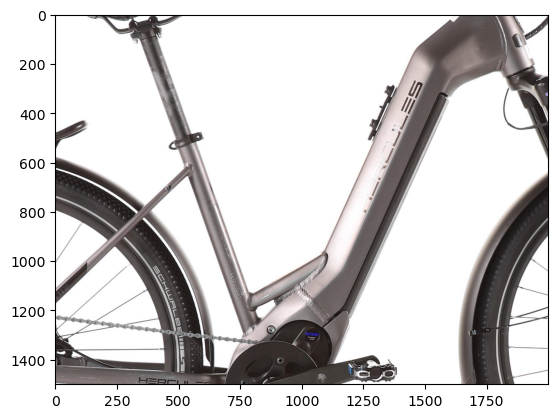

In [3]:
'''

This code is to predict color of the bike from its cropped image.

'''
source_image = cv2.imread('dataset/img_0001_cropped.jpg')

prediction = predict_color(source_image)

print('Color is '+prediction)
plt.imshow(source_image)

In [7]:
color_result = []
for img_id in list(range(len(urls))):

    source_image = cv2.imread('dataset/img_000'+str(img_id+1)+'_cropped.jpg')
    prediction = predict_color(source_image)


    color_result.append(prediction)

In [9]:
gtruth = df['Color'].tolist()

accuracy = []
for i,j in enumerate(color_result):

    if j.lower() == gtruth[i].lower():
        accuracy.append(1)
    else:
        accuracy.append(0)

print('Accuracy of color prediction is '+str(sum(accuracy)/len(accuracy)))

Accuracy of color prediction is 0.7631578947368421


## 3. Brand Detection using OCR

The bike brand is predicted from images using pre-trained keras OCR pipeline.

1. As a first step, the image is preprocessed to highlight the brand labels. The image is flattened and the pixels are clustered. Each cluster label is given a contrast color and thus the pixels in the actual image are assigned those colors.

<div style="display: flex;">
  <div style="flex: 50%; padding: 5px;">
    <img src="dataset/img_0002_cropped.jpg" alt="Image 1" width="400">
    <p style="text-align: center;">Cropped original image</p>
  </div>
  <div style="flex: 50%; padding: 5px;">
    <img src="dataset/brand_recognition/img_0002_highlighted_cropped.jpg" alt="Image 2" width="400">
    <p style="text-align: center;">Processed image </p>
  </div>
</div>


2. The OCR pipepile is implemented to detect and recognise text.


3. The texts extracted from image are checked against brand labels to find the highest matching string and assigned the corresponding brand label. The string with longest contiguous matching subsequence is chosen for each brand label and the pair with the highest similarity score is chosen as the label.

In [ ]:
# Convert the image to RGB (OpenCV uses BGR by default)
for i in tqdm(list(range(len(brands)))):
    contrast_image('img_000'+str(i+1))
    crop_image('img_000'+str(i+1))


/home/ani/mambaforge/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
brands = df['brand_name'].tolist()

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


Looking for /root/.keras-ocr/crnn_kurapan.h5


1/1 [==============================] - 1s 1s/step
The string from list1 with the highest matching is 'habihe'
The corresponding string from list2 is 'haibike'
haibike


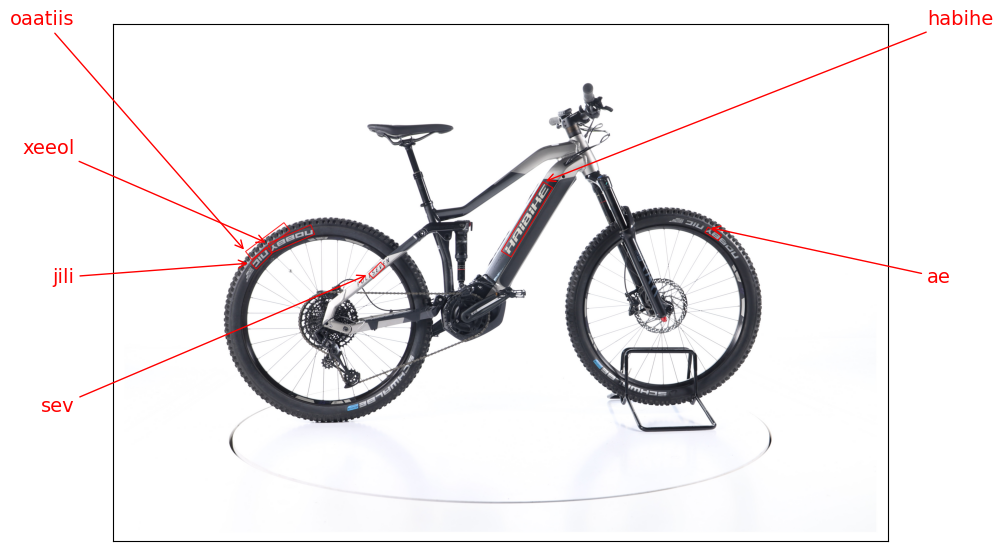

In [25]:

images = [
  keras_ocr.tools.read(img) for img in ['drive/MyDrive/dataset/img_00034.jpg']
]



prediction_groups = pipeline.recognize(images)
prediction_list = []
for i in list(range(len(prediction_groups[0]))):
    prediction_list.append(prediction_groups[0][i][0])

brands = [i.lower() for i in brands]
prediction_list = [i.lower() for i in prediction_list]

list1 = prediction_list
list2 = brands


highest_matching_string_list1, highest_matching_string_list2 = find_highest_matching_strings(list1, list2)
print(f"The string from list1 with the highest matching is '{highest_matching_string_list1}'")
print(f"The corresponding string from list2 is '{highest_matching_string_list2}'")
print(highest_matching_string_list2)


image = images[0]
predictions = prediction_groups[0]

fig, axs = plt.subplots(nrows=1, figsize=(10, 20))

keras_ocr.tools.drawAnnotations(image=image,
                                predictions=predictions,
                                ax=axs)

plt.show()


In [ ]:
result = []
not_clear_list = [1,2,3, 18,20,31,33]
for ind,im in tqdm(enumerate(list(range(len(brands))))):

    if ind in not_clear_list:
        images = [
        keras_ocr.tools.read(img) for img in ['drive/MyDrive/dataset/brand_recognition/img_000'+str(im+1)+'_highlighted_cropped.jpg']
        ]

    else:
        images = [
          keras_ocr.tools.read(img) for img in ['drive/MyDrive/dataset/img_000'+str(im+1)+'_cropped.jpg']
        ]
        
    prediction = predict_brand(brands, images)
    result.append(prediction)

    

np.save('drive/MyDrive/brand_name.npy', result)

0it [00:00, ?it/s]

1/1 [==============================] - 1s 1s/step


1it [01:23, 83.94s/it]

The string from list1 with the highest matching is 'jlles'
The corresponding string from list2 is 'hercules'
1/1 [==============================] - 0s 271ms/step


2it [02:47, 83.77s/it]

The string from list1 with the highest matching is 'arrtec'
The corresponding string from list2 is 'corratec'
1/1 [==============================] - 0s 266ms/step


3it [04:10, 83.33s/it]

The string from list1 with the highest matching is 'acid'
The corresponding string from list2 is 'merida'
1/1 [==============================] - 49s 49s/step


4it [05:00, 70.02s/it]

The string from list1 with the highest matching is 'None'
The corresponding string from list2 is 'None'
1/1 [==============================] - 2s 2s/step


5it [06:24, 75.35s/it]

The string from list1 with the highest matching is 'cannondale'
The corresponding string from list2 is 'cannondale'
1/1 [==============================] - 1s 1s/step


6it [07:49, 78.35s/it]

The string from list1 with the highest matching is 'cube'
The corresponding string from list2 is 'cube'
1/1 [==============================] - 1s 701ms/step


7it [09:12, 79.99s/it]

The string from list1 with the highest matching is 'bosch'
The corresponding string from list2 is 'böttcher'
1/1 [==============================] - 0s 482ms/step


8it [10:22, 76.70s/it]

The string from list1 with the highest matching is 'oc'
The corresponding string from list2 is 'focus'
1/1 [==============================] - 0s 437ms/step


9it [11:45, 78.79s/it]

The string from list1 with the highest matching is 'inteto'
The corresponding string from list2 is 'giant'
1/1 [==============================] - 1s 696ms/step


10it [13:08, 80.20s/it]

The string from list1 with the highest matching is 'cube'
The corresponding string from list2 is 'cube'
1/1 [==============================] - 3s 3s/step


11it [14:34, 81.79s/it]

The string from list1 with the highest matching is 'pegasus'
The corresponding string from list2 is 'pegasus'
1/1 [==============================] - 1s 951ms/step


12it [15:57, 82.35s/it]

The string from list1 with the highest matching is 'rrmsen'
The corresponding string from list2 is 'r raymon'
1/1 [==============================] - 3s 3s/step


13it [16:50, 73.28s/it]

The string from list1 with the highest matching is 'tes'
The corresponding string from list2 is 'stevens'
1/1 [==============================] - 0s 486ms/step


14it [18:13, 76.27s/it]

The string from list1 with the highest matching is 'cube'
The corresponding string from list2 is 'cube'
1/1 [==============================] - 1s 1s/step


15it [19:37, 78.54s/it]

The string from list1 with the highest matching is 'hercules'
The corresponding string from list2 is 'hercules'
1/1 [==============================] - 0s 473ms/step


16it [21:00, 79.94s/it]

The string from list1 with the highest matching is 'me'
The corresponding string from list2 is 'merida'
1/1 [==============================] - 1s 1s/step


17it [22:24, 81.24s/it]

The string from list1 with the highest matching is 'spro'
The corresponding string from list2 is 'sparta'
1/1 [==============================] - 1s 1s/step


18it [23:48, 82.01s/it]

The string from list1 with the highest matching is 'gait'
The corresponding string from list2 is 'giant'
1/1 [==============================] - 0s 479ms/step


19it [24:38, 72.54s/it]

The string from list1 with the highest matching is 'race'
The corresponding string from list2 is 'raleigh'
1/1 [==============================] - 2s 2s/step


20it [25:31, 66.50s/it]

The string from list1 with the highest matching is 'raleigh'
The corresponding string from list2 is 'raleigh'
1/1 [==============================] - 1s 702ms/step


21it [26:54, 71.61s/it]

The string from list1 with the highest matching is 'taus'
The corresponding string from list2 is 'pegasus'
1/1 [==============================] - 1s 874ms/step


22it [28:01, 70.01s/it]

The string from list1 with the highest matching is 'i'
The corresponding string from list2 is 'liv'
1/1 [==============================] - 1s 513ms/step


23it [29:24, 73.95s/it]

The string from list1 with the highest matching is 'cannondale'
The corresponding string from list2 is 'cannondale'
1/1 [==============================] - 3s 3s/step


24it [30:49, 77.41s/it]

The string from list1 with the highest matching is 'sparta'
The corresponding string from list2 is 'sparta'
1/1 [==============================] - 2s 2s/step


25it [32:14, 79.71s/it]

The string from list1 with the highest matching is 'cube'
The corresponding string from list2 is 'cube'
1/1 [==============================] - 1s 698ms/step


26it [33:38, 80.81s/it]

The string from list1 with the highest matching is 'clbe'
The corresponding string from list2 is 'cube'
1/1 [==============================] - 0s 485ms/step


27it [35:01, 81.49s/it]

The string from list1 with the highest matching is 'cube'
The corresponding string from list2 is 'cube'
1/1 [==============================] - 0s 263ms/step


28it [36:24, 81.98s/it]

The string from list1 with the highest matching is 'bosch'
The corresponding string from list2 is 'böttcher'
1/1 [==============================] - 1s 1s/step


29it [37:48, 82.60s/it]

The string from list1 with the highest matching is 'cone'
The corresponding string from list2 is 'cone'
1/1 [==============================] - 2s 2s/step


30it [38:42, 74.15s/it]

The string from list1 with the highest matching is 'i'
The corresponding string from list2 is 'liv'
1/1 [==============================] - 0s 491ms/step


31it [39:32, 66.87s/it]

The string from list1 with the highest matching is 'bosch'
The corresponding string from list2 is 'böttcher'
1/1 [==============================] - 0s 263ms/step


32it [40:38, 66.47s/it]

The string from list1 with the highest matching is 'hmrtts'
The corresponding string from list2 is 'hercules'
1/1 [==============================] - 2s 2s/step


33it [41:29, 61.93s/it]

The string from list1 with the highest matching is 'cube'
The corresponding string from list2 is 'cube'
1/1 [==============================] - 0s 471ms/step


34it [42:21, 58.89s/it]

The string from list1 with the highest matching is 'ullseven'
The corresponding string from list2 is 'stevens'
1/1 [==============================] - 1s 919ms/step


35it [43:25, 60.33s/it]

The string from list1 with the highest matching is 'smes'
The corresponding string from list2 is 'stevens'
1/1 [==============================] - 1s 1s/step


36it [44:49, 67.48s/it]

The string from list1 with the highest matching is 'i'
The corresponding string from list2 is 'liv'
1/1 [==============================] - 1s 707ms/step


37it [46:12, 72.23s/it]

The string from list1 with the highest matching is 'esecmoler'
The corresponding string from list2 is 'riese & mueller'
1/1 [==============================] - 2s 2s/step


38it [47:37, 75.19s/it]

The string from list1 with the highest matching is 'cube'
The corresponding string from list2 is 'cube'


In [ ]:
indices_to_remove = [7,8,16,21]# These images do not have a label in the image
accuracy = []
for i,j in enumerate(brands):
    if i in indices_to_remove:
        pass

    else:

        if j == result[i]:
            accuracy.append(1)
        else:
            accuracy.append(0)

print('Accuracy of predictiong brands is '+str(sum(accuracy)/len(accuracy)))

Accuracy of predictiong brands is 0.6764705882352942


## 4. Binary Classification- Checking for lamp

Binary Classification using a CNN model to check if the bike has a head lamp in the front.

1. Spatial attention is applied using ROI to focus on the necessary features for classification.


<div style="display: flex;">
  <div style="flex: 50%; padding: 5px;">
    <img src="dataset/img_0002.jpg" alt="Image 1" width="400">
    <p style="text-align: center;">Original image used as input</p>
  </div>
  <div style="flex: 50%; padding: 5px;">
    <img src="dataset/roi_lamp/roi_lamp_img_0002.jpg" alt="Image 2" width="400">
    <p style="text-align: center;">Corresponding ROI mask</p>
  </div>
</div>


2. Performance is analysed using GradCAM.

In [ ]:
#Create Region of Interest Images
for i in list(range(len(urls))):
    create_roi_lamp('img_000'+str(i+1))

In [73]:
#Data Loader for training and validation

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, Y, batch_size=8, shuffle=True):
        'Initialization'
        self.dim = (800,600,3)
        self.Y = Y
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_1 = np.empty((self.batch_size, *self.dim))
        X_2 = np.empty((self.batch_size, *self.dim))

        y = np.empty((self.batch_size))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample

            img = tf.keras.preprocessing.image.load_img("drive/MyDrive/dataset/img_000"+str(ID+1)+".jpg", target_size=(800, 600))

            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array /=255

            X_1[i] = img_array


            img2 = tf.keras.preprocessing.image.load_img("drive/MyDrive/dataset/roi_lamp/roi_lamp_img_000"+str(ID+1)+".jpg", target_size=(800, 600))

            img_array2 = tf.keras.preprocessing.image.img_to_array(img2)
            img_array2 /=255

            X_2[i] = img_array2

            y[i] = self.Y[ID]


        return [X_1,X_2], y

In [74]:
#Generate labels

labels = df['Light'].tolist()
labels = [i.lower() for i in labels]
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)



X = list(range(len(labels)))
print(integer_labels)

train_index, val_index = train_test_split(X, test_size=0.2, random_state=42)


training_generator = DataGenerator(train_index,integer_labels, batch_size=8, shuffle=True)
validation_generator = DataGenerator(val_index,integer_labels, batch_size=8, shuffle=True)

[1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0
 0]


In [75]:
#Define Model

#For processing the image
inputs = tf.keras.Input(shape=(800,600,3))
x = tf.keras.layers.Conv2D(32, (5, 5), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((4, 4))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
encoder_output = tf.keras.layers.MaxPooling2D((2, 2))(x)

encoder1 = models.Model(inputs=inputs,outputs=encoder_output)

#For processing ROI
inputs2 = tf.keras.Input(shape=(800,600,3))
x2 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu')(inputs2)
x2 = tf.keras.layers.MaxPooling2D((4, 4))(x2)
x2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D((2, 2))(x2)
x2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D((2, 2))(x2)
x2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x2)
encoder_output2 = tf.keras.layers.MaxPooling2D((2, 2))(x2)

encoder2 = models.Model(inputs=inputs2,outputs=encoder_output2)


network_input_1 = tf.keras.Input(shape=(800,600,3))
network_input_mask = tf.keras.Input(shape=(800,600,3))
encoder_out_1 = encoder1(network_input_1)
encoder_out_2 = encoder2(network_input_mask)

final_output = tf.keras.layers.Multiply()([encoder_out_1, encoder_out_2])

flattened = tf.keras.layers.Flatten()(final_output)
dense = tf.keras.layers.Dense(512, activation='relu')(flattened)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = models.Model(inputs=[network_input_1, network_input_mask], outputs=output)

model.summary()

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 800, 600, 3)]        0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 800, 600, 3)]        0         []                            
                                                                                                  
 model_35 (Functional)       (None, 23, 16, 128)          242368    ['input_19[0][0]']            
                                                                                                  
 model_36 (Functional)       (None, 23, 16, 128)          242368    ['input_20[0][0]']            
                                                                                           

In [76]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])


model.fit(training_generator,validation_data= validation_generator, epochs = 50)

Epoch 1/50
3/3 [==============================] - 45s 13s/step - loss: 0.6940 - accuracy: 0.4167 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 40s 13s/step - loss: 0.6899 - accuracy: 0.7083 - val_loss: 0.6902 - val_accuracy: 0.6250
Epoch 3/50
3/3 [==============================] - 39s 12s/step - loss: 0.6857 - accuracy: 0.5000 - val_loss: 0.6857 - val_accuracy: 0.6250
Epoch 4/50
3/3 [==============================] - 38s 12s/step - loss: 0.6677 - accuracy: 0.7500 - val_loss: 0.6693 - val_accuracy: 0.6250
Epoch 5/50
3/3 [==============================] - 39s 12s/step - loss: 0.6334 - accuracy: 0.8333 - val_loss: 0.6272 - val_accuracy: 0.8750
Epoch 6/50
3/3 [==============================] - 39s 13s/step - loss: 0.5256 - accuracy: 0.9583 - val_loss: 0.6018 - val_accuracy: 0.6250
Epoch 7/50
3/3 [==============================] - 39s 12s/step - loss: 0.5078 - accuracy: 0.7083 - val_loss: 0.5695 - val_accuracy: 0.5000
Epoch 8/50
3/3 [===========

KeyboardInterrupt: 

In [99]:
def preprocess_img(img_path):
    img2 = tf.keras.preprocessing.image.load_img(img_path, target_size=(800, 600))

    img_array2 = tf.keras.preprocessing.image.img_to_array(img2)
    img_array2 = np.expand_dims(img_array2, axis=0)
    img_array2 /=255

    return img_array2

def superimpose(image_path, heatmap):
    # Load the original image
    img = cv2.imread(image_path)

    # Resize the heatmap to be the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return superimposed_img

### GradCAM result of positive predictions

Prediction: 0.9826292


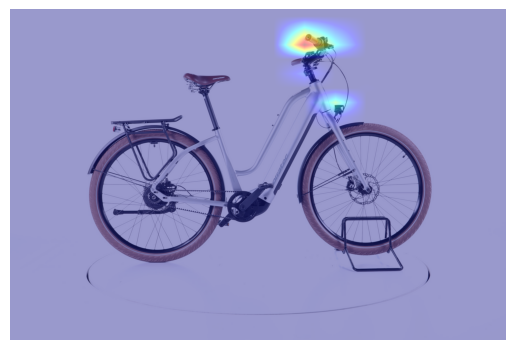

In [100]:

imm = 2


img_array2 = preprocess_img("drive/MyDrive/dataset/roi_lamp/roi_lamp_img_000"+str(imm)+".jpg")
img_array = preprocess_img("drive/MyDrive/dataset/img_000"+str(imm)+".jpg")


grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('multiply_3').output, model.output])

with tf.GradientTape() as tape:
    conv_output, predictions = grad_model([img_array, img_array2])
    loss = predictions[:, 0]  # Consider the class index for the positive class

if predictions[:,0].numpy()[0] > 0.5:
    # Get the gradients of the loss with respect to the output feature map of the last convolutional layer
    grads = tape.gradient(loss, conv_output)

    # Get the channel-wise mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the positive class
    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_output, pooled_grads), axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    heatmap_final = heatmap


    # Superimpose the heatmap on the original image
    superimposed_img = superimpose("drive/MyDrive/dataset/img_000"+str(imm)+".jpg", heatmap_final)

    # Display the results
    print('Prediction: '+str(predictions[:,0].numpy()[0]))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


Prediction: 0.9918414


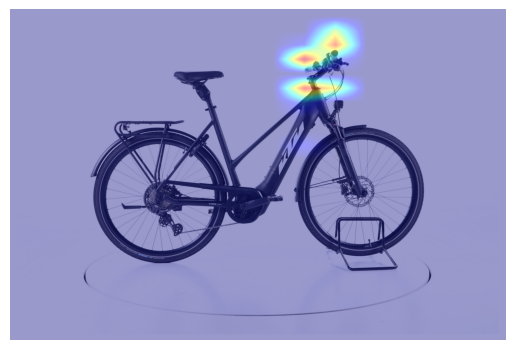

In [104]:
imm = 31


img_array2 = preprocess_img("drive/MyDrive/dataset/roi_lamp/roi_lamp_img_000"+str(imm)+".jpg")
img_array = preprocess_img("drive/MyDrive/dataset/img_000"+str(imm)+".jpg")


grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('multiply_3').output, model.output])

with tf.GradientTape() as tape:
    conv_output, predictions = grad_model([img_array, img_array2])
    loss = predictions[:, 0]  # Consider the class index for the positive class

if predictions[:,0].numpy()[0] > 0.5:
    # Get the gradients of the loss with respect to the output feature map of the last convolutional layer
    grads = tape.gradient(loss, conv_output)

    # Get the channel-wise mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the positive class
    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_output, pooled_grads), axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    heatmap_final = heatmap


    # Superimpose the heatmap on the original image
    superimposed_img = superimpose("drive/MyDrive/dataset/img_000"+str(imm)+".jpg", heatmap_final)

    # Display the results
    print('Prediction: '+str(predictions[:,0].numpy()[0]))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


Prediction: 0.96919495


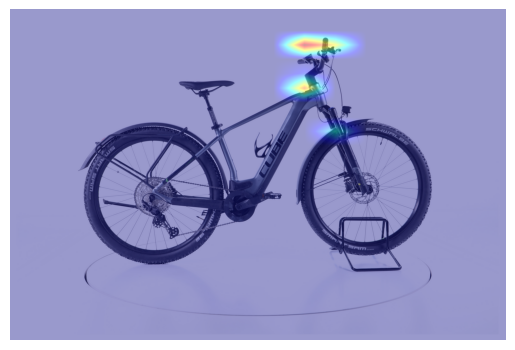

In [105]:
imm = 26


img_array2 = preprocess_img("drive/MyDrive/dataset/roi_lamp/roi_lamp_img_000"+str(imm)+".jpg")
img_array = preprocess_img("drive/MyDrive/dataset/img_000"+str(imm)+".jpg")


grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('multiply_3').output, model.output])

with tf.GradientTape() as tape:
    conv_output, predictions = grad_model([img_array, img_array2])
    loss = predictions[:, 0]  # Consider the class index for the positive class

if predictions[:,0].numpy()[0] > 0.5:
    # Get the gradients of the loss with respect to the output feature map of the last convolutional layer
    grads = tape.gradient(loss, conv_output)

    # Get the channel-wise mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the positive class
    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_output, pooled_grads), axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    heatmap_final = heatmap


    # Superimpose the heatmap on the original image
    superimposed_img = superimpose("drive/MyDrive/dataset/img_000"+str(imm)+".jpg", heatmap_final)

    # Display the results
    print('Prediction: '+str(predictions[:,0].numpy()[0]))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


Prediction: 0.9903512


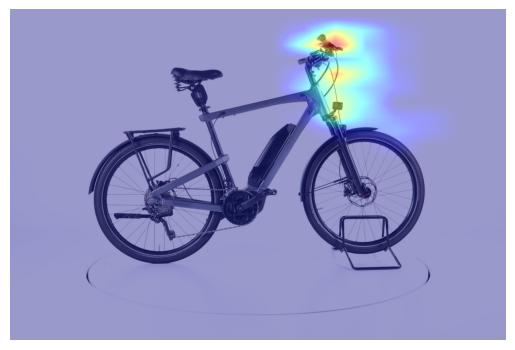

In [101]:
imm = 21

img_array2 = preprocess_img("drive/MyDrive/dataset/roi_lamp/roi_lamp_img_000"+str(imm)+".jpg")
img_array = preprocess_img("drive/MyDrive/dataset/img_000"+str(imm)+".jpg")


grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('multiply_3').output, model.output])

with tf.GradientTape() as tape:
    conv_output, predictions = grad_model([img_array, img_array2])
    loss = predictions[:, 0]  # Consider the class index for the positive class

if predictions[:,0].numpy()[0] > 0.5:
    # Get the gradients of the loss with respect to the output feature map of the last convolutional layer
    grads = tape.gradient(loss, conv_output)

    # Get the channel-wise mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the positive class
    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(tf.multiply(conv_output, pooled_grads), axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    heatmap_final = heatmap


    # Superimpose the heatmap on the original image
    superimposed_img = superimpose("drive/MyDrive/dataset/img_000"+str(imm)+".jpg", heatmap_final)

    # Display the results
    print('Prediction: '+str(predictions[:,0].numpy()[0]))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


### GradCAM result of negative prediction

Prediction: 0.027968131


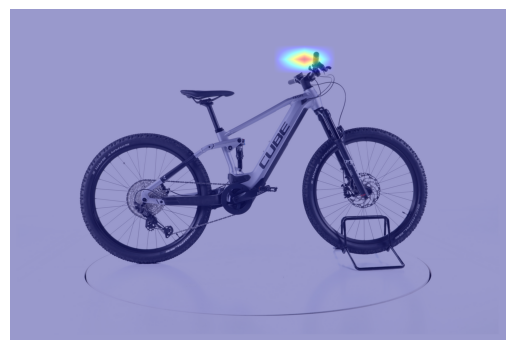

In [103]:

imm = 38

img_array2 = preprocess_img("drive/MyDrive/dataset/roi_lamp/roi_lamp_img_000"+str(imm)+".jpg")
img_array = preprocess_img("drive/MyDrive/dataset/img_000"+str(imm)+".jpg")


grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('multiply_3').output, model.output])

with tf.GradientTape() as tape:
    conv_output, predictions = grad_model([img_array, img_array2])
    loss = predictions[:, 0]  # Consider the class index for the positive class


# Get the gradients of the loss with respect to the output feature map of the last convolutional layer
grads = tape.gradient(loss, conv_output)

# Get the channel-wise mean of the gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each channel in the feature map array by "how important this channel is" with regard to the positive class
conv_output = conv_output[0]
heatmap = tf.reduce_mean(tf.multiply(conv_output, pooled_grads), axis=-1)

# Normalize the heatmap
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

heatmap_final = heatmap


# Superimpose the heatmap on the original image
superimposed_img = superimpose("drive/MyDrive/dataset/img_000"+str(imm)+".jpg", heatmap_final)

# Display the results
print('Prediction: '+str(predictions[:,0].numpy()[0]))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
